In [169]:
import pandas as pd
import os
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import tqdm
import cv2
import matplotlib.pyplot as plt


In [170]:
# read into files to get the data the jpeg files
path = 'archive/face2comics_v1.0.0_by_Sxela/face2comics_v1.0.0_by_Sxela/'
comics_path = path + 'comics/'
face_path = path + 'face/'

comics = []
face = []
for i in os.listdir(comics_path):
    comics.append(comics_path + i)

for i in os.listdir(face_path):
    face.append(face_path + i)

print(comics[0])
print(face[0])

archive/face2comics_v1.0.0_by_Sxela/face2comics_v1.0.0_by_Sxela/comics/0.jpg
archive/face2comics_v1.0.0_by_Sxela/face2comics_v1.0.0_by_Sxela/face/0.jpg


In [171]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [172]:
# work on gpu
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.set_device(0)
    print("Using GPU")

Using GPU


In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Define the encoder (downsampling)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
        
        # Define the decoder (upsampling)
        self.decoder = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 1024, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 3, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(3),
            nn.Tanh()
            # Add more layers as needed
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [174]:
face_train = face[:8000]
comics_train = comics[:8000]


In [ ]:
# Define the transform
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Custom dataset using the two lists
class PairedImageDataset(Dataset):
    def __init__(self, face_paths, comic_paths, transform=None):
        self.face_paths = face_paths
        self.comic_paths = comic_paths
        self.transform = transform

    def __len__(self):
        return len(self.face_paths)

    def __getitem__(self, idx):
        face_image = Image.open(self.face_paths[idx]).convert("RGB")
        comic_image = Image.open(self.comic_paths[idx]).convert("RGB")
        
        if self.transform:
            face_image = self.transform(face_image)
            comic_image = self.transform(comic_image)
        
        return face_image, comic_image

# Assuming 'face' and 'comics' are your lists of image paths
paired_dataset = PairedImageDataset(face_paths=face_train, comic_paths=comics_train, transform=transform)
dataloader = DataLoader(paired_dataset, batch_size=16, shuffle=True)

# Initialize model, loss function, and optimizer
model = UNet().to(device)

# load saved model if exists
model.load_state_dict(torch.load('unet_model.pth'))
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

# Training loop
num_epochs = 30
for epoch in tqdm.tqdm(range(num_epochs)):
    for original, comic in dataloader:
        optimizer.zero_grad()
        original = original.to(device)
        comic = comic.to(device)
        output = model(original)
        loss = criterion(output, comic)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


  3%|▎         | 1/30 [01:22<40:06, 82.98s/it]

Epoch [1/30], Loss: 0.0794


  7%|▋         | 2/30 [02:31<34:40, 74.30s/it]

Epoch [2/30], Loss: 0.0491


 10%|█         | 3/30 [03:39<32:11, 71.53s/it]

Epoch [3/30], Loss: 0.0365


 13%|█▎        | 4/30 [04:47<30:26, 70.25s/it]

Epoch [4/30], Loss: 0.0310


 17%|█▋        | 5/30 [05:55<28:58, 69.52s/it]

Epoch [5/30], Loss: 0.0251


 20%|██        | 6/30 [07:04<27:37, 69.08s/it]

Epoch [6/30], Loss: 0.0284


 23%|██▎       | 7/30 [08:12<26:22, 68.80s/it]

Epoch [7/30], Loss: 0.0205


 27%|██▋       | 8/30 [09:20<25:09, 68.62s/it]

Epoch [8/30], Loss: 0.0219


 30%|███       | 9/30 [10:28<23:58, 68.50s/it]

Epoch [9/30], Loss: 0.0205


 33%|███▎      | 10/30 [11:37<22:48, 68.45s/it]

Epoch [10/30], Loss: 0.0171


 37%|███▋      | 11/30 [12:45<21:39, 68.38s/it]

Epoch [11/30], Loss: 0.0203


 40%|████      | 12/30 [13:53<20:30, 68.34s/it]

Epoch [12/30], Loss: 0.0193


 43%|████▎     | 13/30 [15:01<19:21, 68.31s/it]

Epoch [13/30], Loss: 0.0190


 47%|████▋     | 14/30 [16:10<18:13, 68.32s/it]

Epoch [14/30], Loss: 0.0204


 50%|█████     | 15/30 [17:18<17:05, 68.37s/it]

Epoch [15/30], Loss: 0.0191


 53%|█████▎    | 16/30 [18:27<15:57, 68.36s/it]

Epoch [16/30], Loss: 0.0209


 57%|█████▋    | 17/30 [19:35<14:47, 68.26s/it]

Epoch [17/30], Loss: 0.0189


 60%|██████    | 18/30 [20:43<13:38, 68.20s/it]

Epoch [18/30], Loss: 0.0194


 63%|██████▎   | 19/30 [21:51<12:29, 68.16s/it]

Epoch [19/30], Loss: 0.0212


 67%|██████▋   | 20/30 [22:59<11:21, 68.12s/it]

Epoch [20/30], Loss: 0.0285


 70%|███████   | 21/30 [24:07<10:12, 68.09s/it]

Epoch [21/30], Loss: 0.0164


 73%|███████▎  | 22/30 [25:15<09:04, 68.07s/it]

Epoch [22/30], Loss: 0.0180


 77%|███████▋  | 23/30 [26:23<07:56, 68.05s/it]

Epoch [23/30], Loss: 0.0168


 80%|████████  | 24/30 [27:31<06:48, 68.05s/it]

Epoch [24/30], Loss: 0.0177


 83%|████████▎ | 25/30 [28:39<05:40, 68.04s/it]

Epoch [25/30], Loss: 0.0205


 87%|████████▋ | 26/30 [29:47<04:32, 68.02s/it]

Epoch [26/30], Loss: 0.0218


 90%|█████████ | 27/30 [30:55<03:23, 67.99s/it]

Epoch [27/30], Loss: 0.0202


 93%|█████████▎| 28/30 [32:03<02:15, 67.98s/it]

Epoch [28/30], Loss: 0.0153


 97%|█████████▋| 29/30 [33:11<01:07, 67.99s/it]

Epoch [29/30], Loss: 0.0184


100%|██████████| 30/30 [34:19<00:00, 68.64s/it]

Epoch [30/30], Loss: 0.0152


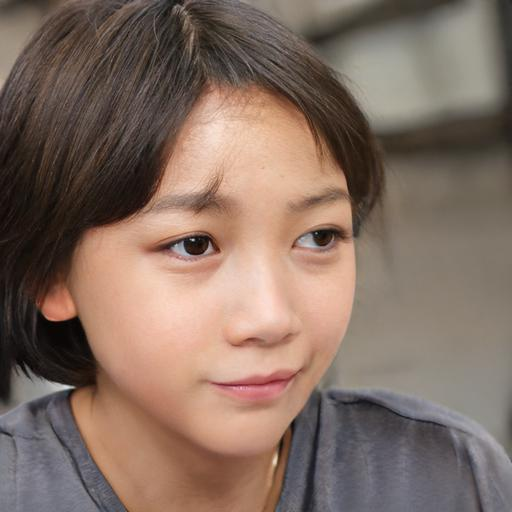

In [185]:
img = Image.open(face[9999]).convert("RGB")
img 

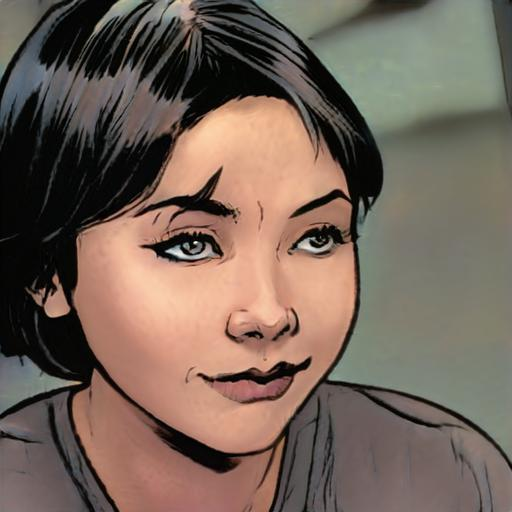

In [186]:
comic_img = Image.open(comics[9999]).convert("RGB")
comic_img

In [187]:
model.eval()

UNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5

In [188]:
out = model(transform(img).reshape(-1, 3, 256, 256).to(device))

In [189]:
out = out.detach().cpu().numpy().reshape(3, 256, 256).transpose(1, 2, 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.96457905].


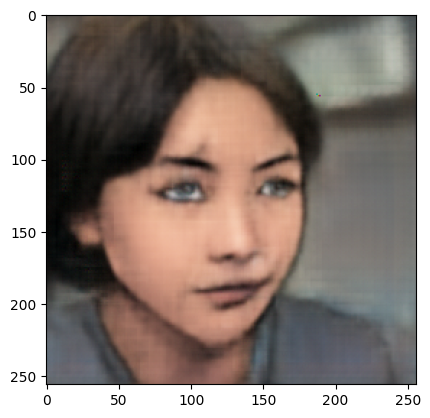

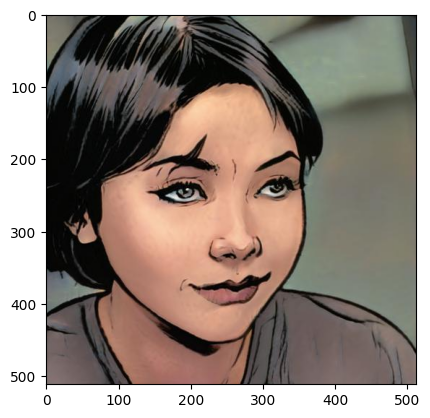

In [190]:
plt.imshow(out)
plt.show()
plt.imshow(comic_img)

In [183]:
for i in dataloader:
    print(i[0].shape)
    break
    

torch.Size([16, 3, 256, 256])


In [184]:
transform(img).shape

torch.Size([3, 256, 256])

In [192]:
# save the model
torch.save(model.state_dict(), 'unet_model.pth')
